<h1>Naive Bayes Classifier</h1>

Naive Bayes classifiers are a family of generative probabilistic clasiifiers that are fast, easy to implement. The _naive_ in the name is due to the assumption that the features of the data are conditionally independent of one another given the class label. This idependence assumption leads to a closed-form maximum likilihood estimation, model complexity that is linear in the number of features, and the statistical advantage that less data is required to obtain useful estimates of model parameters. Because of these conveniences, Naive Bayes models are commonly used as a baseline in natural language processing applications such as document classification, spam filtering, or sentiment analysis. But the speed and simplicity of the model make it a worthwhile consideration for any classification task.

### Bayesian theorm

When two events are independent, their joint probability is the product of each event:

$$P(E\cap F) = P(E)P(F)$$

Their conditional probability is the joint probability divided by the conditional (i.e., P(F)).

$$P(E|F) = \frac{P(E\cap F)}{P(F)}$$
then 
$$ P(E|F)=\frac{P(F|E)P(E)}{P(F)} $$

### What is the Naive Bayes Classifier?

- Naive Bayes is a based on Bayes Theorem.
- It is one of the simplest supervised learning algorithms. 
- Naive Bayes classifier is a fast, accurate, reliable and fast algorithm.

#### Naive Assumption:  each feature  is independent of other features
so
$$P(E|F) = \frac{P(E \cap F)}{P(F)} = \frac{P(E)P(F)}{P(F)}= P(E)$$
similarly
$$P(E \cap F|G) = P(E|G)P(F|G)$$

For example, a loan applicant is desirable or not depending on his/her income, previous loan and transaction history, age, and location. Even if these features are interdependent, these features are still considered independently. This assumption simplifies computation, and that’s why it is considered as naive. This assumption is called class conditional independence.


### How Naive Bayes classifier works?
Let’s understand the working of Naive Bayes through an example. Given an example of weather conditions and playing sports. You need to calculate the probability of playing sports. Now, you need to classify whether players will play or not, based on the weather condition.

### First Approach with just one feature
Naive Bayes classifier calculates the probability of an event in the following steps:

1. Calculate the prior probability for given class labels
1. Find Likelihood probability with each attribute for each class
1. Put these values in Bayes Formula and calculate posterior probability.
1. See which class has a higher probability, given the input belongs to the higher probability class.

The simplified prior and posterior probability can be calculated as follows:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq, kmeans, whiten
from scipy import stats
from collections import Counter
import math
import warnings
import time
import sys
sys.path.append("../data/")

#from mylib import ROC
warnings.filterwarnings("ignore", category = DeprecationWarning) 
warnings.filterwarnings("ignore", category = FutureWarning) 

def fmt(x): return ('%.6f' % x).rjust(10)

In [2]:
df = pd.read_csv('../data/playTennis.csv')
df['one']=1
print(df)
pt1=df.pivot_table(values='one',columns='Play',
                   index='Outlook',  aggfunc='count') #, margins=1)
print('\nTable 1. Counts')
print(pt1)

totalcount=np.nansum(pt1)
print('\ntotal count', totalcount)
print('\nTable 2. Prior probability without using the outcome')
print(pt1/totalcount)

columncount=np.nansum(pt1,0)
print('\ncolumn count', columncount)
print('\nTable 3. Posterior probability for each outcome')
print(pt1/columncount)


     Outlook Temperature Humidity  Windy Play  one
0      sunny         hot     high  False   No    1
1      sunny         hot     high   True   No    1
2   overcast         hot     high  False  Yes    1
3       rain        mild     high  False  Yes    1
4       rain        cool  Noormal  False  Yes    1
5       rain        cool  Noormal   True   No    1
6   overcast        cool  Noormal   True  Yes    1
7      sunny        mild     high  False   No    1
8      sunny        cool  Noormal  False  Yes    1
9       rain        mild  Noormal  False  Yes    1
10     sunny        mild  Noormal   True  Yes    1
11  overcast        mild     high   True  Yes    1
12  overcast         hot  Noormal  False  Yes    1
13      rain        mild     high   True   No    1

Table 1. Counts
Play       No  Yes
Outlook           
overcast  NaN  4.0
rain      2.0  3.0
sunny     3.0  2.0

total count 14.0

Table 2. Prior probability without using the outcome
Play            No       Yes
Outlook               

In [3]:
df.loc[df["Play"] == "No"]

,Outlook,Temperature,Humidity,Windy,Play,one
0,sunny,hot,high,False,No,1
1,sunny,hot,high,True,No,1
5,rain,cool,Noormal,True,No,1
7,sunny,mild,high,False,No,1
13,rain,mild,high,True,No,1


In [4]:
## to make it into one piece
def FeatureTable(df, field):
    pt1=df.pivot_table(values='one', columns='Play', index=field,  aggfunc='count') 
    pt1[pt1.isna()]=0 #将透视表 pt1 中的缺失值（NaN）替换为 0，便于后续计算。
    totalcount=int(np.nansum(pt1)) #总计数
    columncounts=np.nansum(pt1,0) #按列计数
    pt=pd.concat([pt1,pt1/totalcount, pt1/columncounts],1)
    pt.columns=['No','Play','Prior for No','Prior for Yes','Posterior for No','Posterior for Yes']
    display(pt)   ### Hey!, this is cool
    print('Total count', totalcount, ' ColumnCounts', columncounts.astype(np.int16))
    return pt, totalcount, columncounts

t1=FeatureTable(df, 'Outlook')
t2=FeatureTable(df, 'Temperature')

,No,Play,Prior for No,Prior for Yes,Posterior for No,Posterior for Yes
Outlook,,,,,,
overcast,0.0,4.0,0.000000,0.285714,0.0,0.444444
rain,2.0,3.0,0.142857,0.214286,0.4,0.333333
sunny,3.0,2.0,0.214286,0.142857,0.6,0.222222


Total count 14  ColumnCounts [5 9]


,No,Play,Prior for No,Prior for Yes,Posterior for No,Posterior for Yes
Temperature,,,,,,
cool,1,3,0.071429,0.214286,0.2,0.333333
hot,2,2,0.142857,0.142857,0.4,0.222222
mild,2,4,0.142857,0.285714,0.4,0.444444


Total count 14  ColumnCounts [5 9]


### Classification with multiple features

Now we want to find out whether to play tennis based on two facts: Outlook and Temperature. We are comparing two pababilities:
   
   $$P(Play= Yes | Outlook=Overcast \cap Temp=Mild) $$
   and
      $$P(Play= No | Outlook=Overcast \cap Temp=Mild)$$

our decision will be made after evaluate both probabilities and chose the one with higher probability

In general, if we have $k$ classes $y_i \in \{y_1, y_2, ..., y_k\}$, and a vector of $m$ features $X_1, X_2, ..., X_m$, we want to find the class yi that maximizes

$$P(y_i | X_1\cap X_2\cap ...\cap X_m) = \frac {P(X_1\cap X_2\cap...\cap X_m\cap y_i)}{P(X_1\cap X_2\cap...\cap X_m)} $$

Notice that the denominator is constant and it does not depend on the class yi. <u>So, we can ignore it and just focus on the numerator. !!!</u>

According to the Bayesian theorm 

$$P(X_1\cap X_2\cap...\cap X_n\cap y_i) = P(X_1 | X_2\cap...\cap X_n\cap y_i)P(X_2 | X_3\cap...\cap X_n\cap y_i)...P(X_n | y_i)P(y_i)$$

with Naive Bayesian assumption, all features are independent

$$P(y_i | X_1\cap X_2\cap...\cap X_n) = \frac{P(X_1\cap X_2\cap...\cap X_n | yi)P(y_i)}{P(X_1\cap X_2\cap...\cap X_n)}
= \frac{P(X_1 | y_i)P(X_2 | y_i)...P(X_n | y_i)P(y_i)}{P(X_1\cap X_2\cap ...\cap X_n)} $$

And we just need to focus on the numerator.

Thus the probability of playing when Weather=Overcast, Temp=Mild can be computed as follows

1. Prior Probabilities: P(play=Yes)= 9/14 = 0.64
1. Posterior Probabilities: P(Overcast |play=Yes) = 4/9 = 0.44  and P(Mild |play=Yes) = 4/9 = 0.44
1. P(Weather=Overcast, Temp=Mild | Play=Yes) = 0.44 * 0.44 = 0.1936
1. P(Play= Yes | Weather=Overcast, Temp=Mild) = 0.1936*0.64 = 0.124

and for case of not to play

1. Prior Probabilities: P(play=No)= 5/14 = 0.36
1. Posterior Probabilities: P(Overcast |play=No) = 0/9 = 0  and P(Mild |play=No) = 2/9 = 0.22
1. P(Weather=Overcast, Temp=Mild | Play=No) = 0 * 0.22 = 0
1. P(Play= No | Weather=Overcast, Temp=Mild) = 0 * 0.36 = 0

Well, we are out for the playing.

</font>

### Row based algorithm

In [6]:
class NaiveBayesClassifier1:
    
    def __init__(self, X, y):
        self.X, self.y = X, y         
        self.N,self.dim = self.X.shape 
        self.output_counts = {} # Output classes with the number of ocurrences in the training set.
        self.data = [] # To store every row [Xi, yi]
        
        for i in range(self.N):                    
            ## get counts
            if self.y[i] not in self.output_counts.keys():
                self.output_counts[self.y[i]] = 1
            else: #{"No":5,"Yes":9}
                self.output_counts[self.y[i]] += 1
            # store the row 
            self.data.append([self.X[i], self.y[i]]) ## each row is [array, val]

    def classify(self, entry):
        solve = None    # Final result
        maxprob = -1    # partial maximum
        for y in self.output_counts.keys():#self.output_counts={"No":5,"Yes":9}
            prob = self.output_counts[y]/self.N # P(y)
            ycount = self.output_counts[y]
            for j in range(self.dim):
                entryj = entry[j]   
                n=0
                for xi,yi in self.data:  
                    if yi == y and xi[j] == entryj:   ## move yi==y to the front will save 1 µs 
                        n += 1
                #(np.array(self.data)[:,j]==entryj)*(np.array(self.data)[:,self.dim]==y)
                #cases = [1 for xi,yi in self.data if xi[j] == entry[j] and yi == y] # all rows with Xi = xi  ##21 µs 
                #n = len(cases)
                prob = prob*n/ycount 
                #n/ycount= P(Xi = xi|Y=y)
                
            # if we have a greater prob for this output than the partial maximum...
            if prob > maxprob:
                maxprob, yhat = prob, y
        return yhat
    
    def predict(self, X):
        self.preds=[]
        for _, x in enumerate(X):
            self.preds.append(self.classify(x))
        return np.array(self.preds)

t0 = time.time()
df = pd.read_csv('../data/playTennis.csv')
X=df[['Outlook','Temperature','Humidity','Windy']].to_numpy()
y=df['Play'].to_numpy()

nbc=NaiveBayesClassifier1(X,y)
nbc.classify(['sunny','hot','high',True])
print(nbc.predict(X))
print( (y==nbc.predict(X)).mean() )
print("time:",time.time()-t0)

['No' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'No']
0.9285714285714286
time: 0.006022930145263672


In [7]:
nbc.output_counts

{'No': 5, 'Yes': 9}

In [8]:
nbc.data[1]

[array(['sunny', 'hot', 'high', True], dtype=object), 'No']

### Column based approach using np functions

In [9]:
class NaiveBayesClassifier2:
    
    def __init__(self, X, y):
        if type(X)==pd.DataFrame:
            self.X=X.to_numpy()
        else:
            self.X=X
        if type(y)==pd.DataFrame:
            self.y=y.to_numpy()
        else:
            self.y=y.copy()
            
        self.N = self.X.shape[0] # Length of the training set
        self.dim = self.X.shape[1] # Dimension of the vector of features
        self.output_counts = {} # Output classes with the number of ocurrences in the training set.
        self.data = [] # To store every row [Xi, yi]
        
        for j in range(self.dim):
            self.data.append(self.X[:,j])
                    
        ## get counts
        
        #y_labels = np.unique(self.y)
        #for i in y_labels:
         #   self.output_counts[i]=(i==y).sum()
            
        for i in range(self.N):
            if not self.y[i] in self.output_counts.keys():
                self.output_counts[self.y[i]] = 1
            else:
                self.output_counts[self.y[i]] += 1

    def classify(self, entry):
        solve = None    # Final result
        maxprob = -1    # partial maximum
        for y in self.output_counts.keys():
            prob = self.output_counts[y]/self.N # P(y)
            ycount=self.output_counts[y]
            yselector = (self.y==y)
            for j in range(self.dim):
                length=len(self.data[j][np.logical_and(yselector, self.data[j]==entry[j])])
    #•	逻辑与操作：对 yselector 和 self.data[j] == entry[j] 进行逐元素逻辑与运算。
	#•	作用：筛选出同时满足以下条件的行：
	#•	yselector 中的布尔值为 True。
	#•	self.data[j] 的值等于 entry[j]。
	#•	结果是一个布尔数组。
                prob = prob*length/ycount # P *= P(Xi = xi)
            #print(y, entry, prob)   
            # if we have a greater prob for this output than the partial maximum...
            if prob > maxprob:
                maxprob, solve = prob,y 
        return solve

    def predict(self, X):
        if type(X)==pd.DataFrame:
            X=X.to_numpy()
        self.preds=[]
        for i, x in enumerate(X):
            rt=self.classify(x)
            self.preds.append(rt)
        return np.array(self.preds)

t0 = time.time()
df = pd.read_csv('../data/playTennis.csv')
X=df[['Outlook','Temperature','Humidity','Windy']].to_numpy()
y=df['Play'].to_numpy()

nbc=NaiveBayesClassifier2(X,y)
nbc.classify(['sunny','hot','high',True])
nbc.predict(X)
print("time:",time.time()-t0)

time: 0.0041561126708984375


The enssential difference between two blocks!!!
 <pre>
             for j in range(self.dim):
                entryj = entry[j]   
                n=0
                for xi,yi in self.data:  
                    if yi == y and xi[j] == entryj:   ## move yi==y to the front will save 1 µs 
                        n += 1
 </pre>
<pre>
            for j in range(self.dim):
                length=len(self.data[j][np.logical_and(yselector, self.data[j]==entry[j])])
                prob = prob*length/ycount
 </pre>
 


In [10]:
X.shape

(14, 4)

In [11]:
a=[0,1,0,1,0]
b=[1,1,1,1,0]
np.logical_and(np.array(a),np.array(b))

array([False,  True, False,  True, False])

In [12]:
(np.array(a)==1)*(np.array(b)==0)

array([False, False, False, False, False])

### Testing with larger dataset

In [6]:
svy40=pd.read_csv('/Users/dongwenou/Downloads/Intro to DS/svy40.csv') 
print(svy40.shape)
df40=svy40.iloc[0:1000,:] #.copy() 
ispoor=(df40['LNY']<=10)

colsToDrop=['_ID_','CID','LNY','HD_AGESQ', 'HH_LOGSIZE']
for c in colsToDrop: del df40[c]

np.random.seed(1234)
selector=np.random.uniform(0,1, df40.shape[0])<0.1
print(df40)

(38366, 15)
     DW_BASIC  DW_WATER  EA  HD_AGE  HD_EDU  HD_EMP  HD_FEMALE  HD_MARRIED  \
0           1         1   0      42       5       1          0           1   
1           1         3   0      52       4       1          0           1   
2           1         1   0      70       1       1          0           1   
3           1         2   0      49       3       1          0           1   
4           0         2   0      51       1       1          1           0   
..        ...       ...  ..     ...     ...     ...        ...         ...   
995         1         2   2      64       2       1          0           1   
996         1         2   2      32       2       1          0           1   
997         1         1   2      62       4       1          0           0   
998         0         4   2      40       3       1          0           1   
999         0         5   2      42       4       1          0           1   

     HD_OLF  HD_UNEMP  
0         0         0  
1  

In [14]:
selector.mean()

0.106

In [15]:
da=np.array(df40)
X_test, y_test=da[selector,:], ispoor[selector].to_numpy()
X_train, y_train=da[~selector,:], ispoor[~selector].to_numpy()

In [16]:
t0 = time.time()
nbc=NaiveBayesClassifier1(X_train,y_train)
y_pred1=nbc.predict(X_test)
print(time.time()-t0)

1.891563892364502


In [17]:
t0 = time.time()
nbc=NaiveBayesClassifier2(X_train,y_train)
y_pred2=nbc.predict(X_test)
print(time.time()-t0)

0.012243270874023438


In [18]:
(np.array(y_test)==y_pred1).sum()/len(y_test)

0.6886792452830188

In [19]:
(np.array(y_test)==y_pred2).sum()/len(y_test)

0.6886792452830188

### Can we pre-calculate all the probabilities?

All the probabilities can be computed with the train set. The prediction can just focus on picking up right probabilities and multiply them.
</font>

In [20]:
df = pd.read_csv('../data/playTennis.csv')
df.insert(0,'one',1)
t1=FeatureTable(df, 'Outlook')
t2=FeatureTable(df, 'Temperature')
t3=FeatureTable(df, 'Humidity')
t4=FeatureTable(df, 'Windy')

,No,Play,Prior for No,Prior for Yes,Posterior for No,Posterior for Yes
Outlook,,,,,,
overcast,0.0,4.0,0.000000,0.285714,0.0,0.444444
rain,2.0,3.0,0.142857,0.214286,0.4,0.333333
sunny,3.0,2.0,0.214286,0.142857,0.6,0.222222


Total count 14  ColumnCounts [5 9]


,No,Play,Prior for No,Prior for Yes,Posterior for No,Posterior for Yes
Temperature,,,,,,
cool,1,3,0.071429,0.214286,0.2,0.333333
hot,2,2,0.142857,0.142857,0.4,0.222222
mild,2,4,0.142857,0.285714,0.4,0.444444


Total count 14  ColumnCounts [5 9]


,No,Play,Prior for No,Prior for Yes,Posterior for No,Posterior for Yes
Humidity,,,,,,
Noormal,1,6,0.071429,0.428571,0.2,0.666667
high,4,3,0.285714,0.214286,0.8,0.333333


Total count 14  ColumnCounts [5 9]


,No,Play,Prior for No,Prior for Yes,Posterior for No,Posterior for Yes
Windy,,,,,,
False,2,6,0.142857,0.428571,0.4,0.666667
True,3,3,0.214286,0.214286,0.6,0.333333


Total count 14  ColumnCounts [5 9]


We want to use the following data structure to store the information
<pre>
x_new = ['sunny','hot','high',True]
{'Outlook': {
     'No':  [{'sunny': 0.6, 'rain': 0.4}, 5],
    'Yes':  [{'overcast': 0.44444444, 'rain': 0.33333333, 'sunny': 0.22222222},   9]
  },
 'Temperature':{
     'No':  [{'hot': 0.4, 'cool': 0.2, 'mild': 0.4}, 5],
    'Yes':  [{'hot': 0.22222222, 'mild': 0.44444444, 'cool': 0.33333333}, 9]
  },
 'Humidity':{
     'No':  [{'high': 0.8, 'normal': 0.2}, 5],
    'Yes':  [{'high': 0.33333333, 'normal': 0.66666666}, 9]
  },
 'Windy':{
     'No':  [{False: 0.4, True: 0.6}, 5],
    'Yes':  [{False: 0.66666666, True: 0.33333333}, 9]
  }
}
</pre>

In [21]:
class NaiveBayesClassifierFast:
    
    def __init__(self, X:pd.DataFrame, y:np.array):
        self.X, self.y = X, y         
        self.N = self.X.shape[0] #Length of the training set
        self.dim = self.X.shape[1] #Dimension of the vector of features
        self.label_counts = {} #Output classes with the number of ocurrences in the training set.
        self.perFeaturePerLabelCounts = {} #store per feature per label counts
        self.data = [] # To store every row [Xi, yi]
        
        for i in range(self.N):                   
            ##get counts
            if self.y[i] not in self.label_counts.keys():
                self.label_counts[self.y[i]] = 1
            else:
                self.label_counts[self.y[i]] += 1
        for yi in self.label_counts:
            self.label_counts[yi]/=self.N 
        self.nlabels=len(self.label_counts.keys())

        for field in X:
            F = X[field].to_numpy()
            fyCounts={}
            for yi in self.label_counts:
                fyCounts[yi]=[{},0] #{'No':[{},0],'Yes':[{},0]}
            for i in range(self.N):
                yi=y[i]
                key=F[i] #当前特征的值
                fyCounts[yi][1]+=1
                if key not in fyCounts[yi][0]:
                    fyCounts[yi][0][key] = 0 
                fyCounts[yi][0][key]+=1     #算每个特征值出现多少次           
            for yi in fyCounts:
                for key in fyCounts[yi][0]:
                    fyCounts[yi][0][key]/=fyCounts[yi][1] #归一为概率
            
            self.perFeaturePerLabelCounts[field]=fyCounts    
                
    def classify(self, entry:pd.Series):
        maxprob=-1
        label=None
        denomProb=0
        for yi in self.label_counts:
            prob=self.label_counts[yi]
            for field,val in zip(entry.index, entry):
                ## we can get the probability from self.perFeaturePerLabelCounts[field][yi][0][val]
                ## but we have to make sure it exists
                if self.perFeaturePerLabelCounts.get(field)==None: continue
                if self.perFeaturePerLabelCounts[field].get(yi)==None: continue
                if self.perFeaturePerLabelCounts[field][yi][0].get(val)==None: continue
                prob*=self.perFeaturePerLabelCounts[field][yi][0][val]
                #print(yi, field, val, self.perFeaturePerLabelCounts[field][yi][0][val])
            denomProb+=prob
            if prob>maxprob:
                maxprob=prob
                label=yi
        return label, maxprob/denomProb                    
    
    def predict(self, X):
        preds=[]
        self.probs=np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            pred, self.probs[i]=self.classify(X.iloc[i,:])
            preds.append(pred)
        self.preds=np.array(preds) ## because we don't know the type of the outcome
        return self.preds

df = pd.read_csv('../data/playTennis.csv')
X=df[['Outlook','Temperature','Humidity','Windy']]
y=df['Play'].to_numpy()

nbc=NaiveBayesClassifierFast(X,y)
print(nbc.perFeaturePerLabelCounts['Outlook']['No'][0]['sunny'])
#nbc.classify(X.iloc[0,:])
%timeit 
pred=nbc.predict(X)
pred

0.6


array(['No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes',
       'Yes', 'No', 'Yes', 'No'], dtype='<U3')

In [22]:
print(nbc.perFeaturePerLabelCounts)

{'Outlook': {'No': [{'sunny': 0.6, 'rain': 0.4}, 5], 'Yes': [{'overcast': 0.4444444444444444, 'rain': 0.3333333333333333, 'sunny': 0.2222222222222222}, 9]}, 'Temperature': {'No': [{'hot': 0.4, 'cool': 0.2, 'mild': 0.4}, 5], 'Yes': [{'hot': 0.2222222222222222, 'mild': 0.4444444444444444, 'cool': 0.3333333333333333}, 9]}, 'Humidity': {'No': [{'high': 0.8, 'Noormal': 0.2}, 5], 'Yes': [{'high': 0.3333333333333333, 'Noormal': 0.6666666666666666}, 9]}, 'Windy': {'No': [{False: 0.4, True: 0.6}, 5], 'Yes': [{False: 0.6666666666666666, True: 0.3333333333333333}, 9]}}


In [26]:
dic = {"a":2,"b":3,}
dic['a']
dic['d']
print(dic.get('d'))

None


In [27]:
dtt = nbc.perFeaturePerLabelCounts
print("------------",dtt.get('Out'))
print(dtt['Out']) # error

------------ None


KeyError: 'Out'

In [28]:
print(nbc.perFeaturePerLabelCounts['Outlook']['No'][0]['sunny'])

0.6


In [29]:
for i in X:
    print(i)

Outlook
Temperature
Humidity
Windy


In [30]:
X_test, y_test=df40.loc[selector,:], ispoor[selector].to_numpy()
X_train, y_train=df40.loc[~selector,:], ispoor[~selector].to_numpy()
t0 = time.time()
nbcf=NaiveBayesClassifierFast(X_train,y_train)
y_pred3=nbcf.predict(X_test)
print(time.time()-t0)

0.0216677188873291


In [31]:
X_train

,DW_BASIC,DW_WATER,EA,HD_AGE,HD_EDU,HD_EMP,HD_FEMALE,HD_MARRIED,HD_OLF,HD_UNEMP
0,1,1,0,42,5,1,0,1,0,0
1,1,3,0,52,4,1,0,1,0,0
2,1,1,0,70,1,1,0,1,0,0
3,1,2,0,49,3,1,0,1,0,0
4,0,2,0,51,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
995,1,2,2,64,2,1,0,1,0,0
996,1,2,2,32,2,1,0,1,0,0
997,1,1,2,62,4,1,0,0,0,0
998,0,4,2,40,3,1,0,1,0,0


### Calling the sklearn

In [32]:
from sklearn.naive_bayes import BernoulliNB
t0 = time.time()
model = BernoulliNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
print(time.time()-t0)

0.008945226669311523


In [33]:
print((y_pred==y_test).sum()/len(y_test))
print((y_pred1==y_test).sum()/len(y_test))
print((y_pred2==y_test).sum()/len(y_test))
print((y_pred3==y_test).sum()/len(y_test))

0.6415094339622641
0.6886792452830188
0.6886792452830188
0.6886792452830188


### converting all the string fields to number

In [8]:
def toNumber(df, vars):
    DF=df.copy()
    for col in df:
        if col in vars:
            cc=pd.Categorical(df[col])
            DF[col]=cc.codes+1
    return DF
toNumber(df, ['Outlook','Temperature','Humidity','Windy'])

NameError: name 'df' is not defined

In [35]:
da=np.array(df40)

X_test, y_test=da[selector,:], ispoor[selector].to_numpy()
X_train, y_train=da[~selector,:], ispoor[~selector].to_numpy()

nbc=NaiveBayesClassifier2(X_train,y_train)
%time y_pred=nbc.predict(X_test)

CPU times: user 22.2 ms, sys: 2.55 ms, total: 24.8 ms
Wall time: 31.8 ms


In [36]:
ndf40=toNumber(df40, df40.columns)
da = np.array(ndf40)
X_test, y_test=da[selector,:], ispoor[selector].to_numpy()
X_train, y_train=da[~selector,:], ispoor[~selector].to_numpy()

nbc=NaiveBayesClassifier2(X_train,y_train)
%time y_pred=nbc.predict(X_test)

CPU times: user 15.4 ms, sys: 129 µs, total: 15.5 ms
Wall time: 15.6 ms


In [37]:
da=np.array(df40)

X_test, y_test=df40.loc[selector,:], ispoor[selector].to_numpy()
X_train, y_train=df40.loc[~selector,:], ispoor[~selector].to_numpy()

nbc=NaiveBayesClassifierFast(X_train,y_train)
%time y_pred=nbc.predict(X_test)

CPU times: user 10 ms, sys: 151 µs, total: 10.2 ms
Wall time: 10.2 ms


In [38]:
ndf40=toNumber(df40, df40.columns)
X_test, y_test=ndf40.loc[selector,:], ispoor[selector].to_numpy()
X_train, y_train=ndf40.loc[~selector,:], ispoor[~selector].to_numpy()

nbc=NaiveBayesClassifierFast(X_train,y_train)
%time y_pred=nbc.predict(X_test)

CPU times: user 19.9 ms, sys: 54 µs, total: 20 ms
Wall time: 20 ms


### Issues in Naive Bayes classification

- continueous variable https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote05.html

or https://www.cs.toronto.edu/~urtasun/courses/CSC411_Fall16/09_naive_bayes.pdf
- The Zero-Frequency Problem

One of the disadvantages of Naive-Bayes is that if you have no occurrences of a class label and a certain attribute value together then the frequency-based probability estimate will be zero. And this will get a zero when all the probabilities are multiplied.

An approach to overcome this ‘zero-frequency problem’ in a Bayesian environment is to add some value to the count for every attribute value-class combination when an attribute value doesn’t occur with every class value.

### Multinomial Naive Bayes (MultinomialNB)
According to the documentation in <b>scikit-learn</b>: https://scikit-learn.org/stable/modules/naive_bayes.html.

see also
https://donernesto.github.io/blog/notes-on-multinomial-naive-bayes/
and
https://www.inf.ed.ac.uk/teaching/courses/inf2b/learnSlides/inf2b-learnlec07-full.pdf
<br>

MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification.
The distribution is parametrized by vectors $P_y=(P_{y1},P_{y2},...,P_{yp})$ for each class , where $p$  is the number of features (in text classification, the size of the vocabulary) and $P_{yi}$ is the probability $P(x_i|y)$ of feature $i$ appearing in a sample belonging to class $y$.
 
<p>The parameters <span class="math notranslate nohighlight">\(\hat{P}_y\)</span> is estimated by a smoothed
version of maximum likelihood, i.e. relative frequency counting:</p>

$$ \hat{P}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha p} $$

<p>where $ N_{yi} = \sum_{x \in T} x_i $ is the number of times feature $i$ appears in a sample of class $y$
in the training set $T$, and $$ N_{y} = \sum_{i=1}^{p} N_{yi} $$ is the total count of
all features for class $y$.</p>
<p>The smoothing priors $\alpha \ge 0$ accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting $\alpha=1$ is called <b>Laplace</b> smoothing, while $\alpha<1$  is called <b>Lidstone</b> smoothing.
</font>

For example:
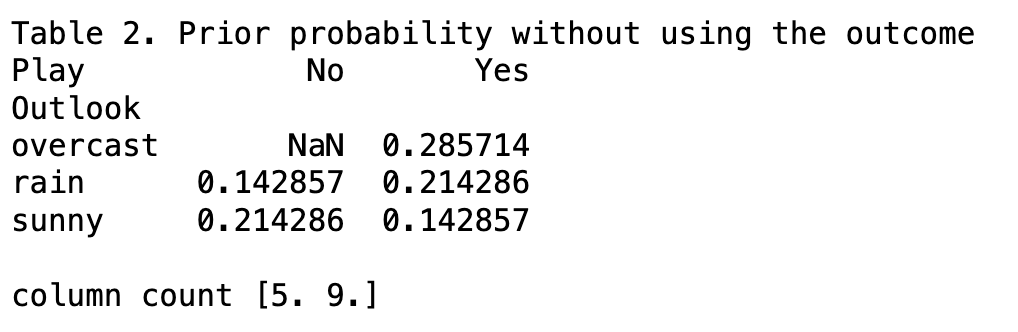

In [39]:
class NaiveBayesClassifierLaplace:
    ## some improvement were made based on NaiveBayesClassifierFast
    ## 1. use the uniqueness of set to get proper ordered label list. self.labels=sorted(list(set(self.y)))
    ## 2. function predict_proba() were added for estimating the probability matrix, each column corresponce to the label in self.labels
    ## 3. function estimate() returns whole probability vector without selecting the highest value, so both predict()
    ##    and predict_proba() can use it to simplify the computation
    ## 4. Laplace smoothing were added 
    
    def __init__(self, X:pd.DataFrame, y:np.array, alpha=1):
        assert type(X)==pd.DataFrame, "X must be a DataFrame"
        self.y = y    
        if type(y)==pd.Series: self.y=y.to_numpy()
        self.N = X.shape[0] # Length of the training set
        self.dim = X.shape[1] # Dimension of the vector of features
        self.labels=sorted(list(set(self.y)))  ## make sure it is sorted so it is independent from the order in y
        self.nlabels=len(self.labels)
        self.label_counts = {} # Output classes with the number of ocurrences in the training set.
        self.perFeaturePerLabelCounts = {} # store per feature per label counts
        
        self.label_counts={label:0 for label in self.labels}
        one_N=1/self.N
        for i in range(self.N):                   
            self.label_counts[self.y[i]] += one_N

        for field in X:
            F=X[field].to_numpy()
            fyCounts={}
            for yi in self.label_counts:
                fyCounts[yi]=[{},0]
            for i in range(self.N):
                yi=y[i]
                key=F[i]
                fyCounts[yi][1]+=1
                if key not in fyCounts[yi][0]:
                    fyCounts[yi][0][key]=0
                fyCounts[yi][0][key]+=1
                               
            for yi in fyCounts:
                alpha_N=alpha*self.dim  ## the denominator in Laplace smoothing
                for key in fyCounts[yi][0]:
                    fyCounts[yi][0][key]=(fyCounts[yi][0][key]+alpha)/(fyCounts[yi][1]+alpha_N) ## Laplace smoothing
                fyCounts[yi][1] = (0+alpha)/(fyCounts[yi][1]+alpha_N) ## keep the probability for non-existent feature value
            self.perFeaturePerLabelCounts[field]=fyCounts    
                
    def estimate(self, entry:pd.Series):  
        probs=np.zeros(self.nlabels,dtype=np.float32) ## get ready to receive the numerator for each label
        for i, yi in enumerate(self.label_counts):
            prob=self.label_counts[yi]  
            for field,val in zip(entry.index, entry):
                ## we can get the probability from self.perFeaturePerLabelCounts[field][yi][0][val]
                ## but we have to make sure it exists
                if self.perFeaturePerLabelCounts.get(field)==None: continue
                if self.perFeaturePerLabelCounts[field][yi][0].get(val)==None:  ## feature value not exist, 
                    prob*=self.perFeaturePerLabelCounts[field][yi][1]     ### use Laplace smoothing
                else:
                    prob*=self.perFeaturePerLabelCounts[field][yi][0][val]
            probs[i]=prob
        return probs  ## return an array
    
    def classify(self, entry:pd.Series):
        return self.label_counts.keys[np.argmax(self.estimate(entry))]  ## use argmax to select the label
    
    def predict(self, X):
        preds=[]
        for i in range(X.shape[0]):
            imax=np.argmax(self.estimate(X.iloc[i,:])) 
            preds.append(self.labels[imax])
        return np.array(preds)
    
    def predict_proba(self, X):
        probs=[]  
        for i in range(X.shape[0]):
            probai=self.estimate(X.iloc[i,:])
            probs.append(list(probai/sum(probai)))
        return np.array(probs)  # the output will be a n by k matrix

df = pd.read_csv('../data/playTennis.csv')
X=df[['Outlook','Temperature','Humidity','Windy']]
y=df['Play'].to_numpy()

nbcl=NaiveBayesClassifierLaplace(X,y,alpha=0.1)
#nbc.classify(X.iloc[0,:])
pred=nbcl.predict(X)
print(pred)
prob=nbcl.predict_proba(X)
print(prob)
nbcl.perFeaturePerLabelCounts

['No' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'No']
[[0.77419543 0.22580455]
 [0.90875316 0.09124678]
 [0.05361187 0.9463881 ]
 [0.4462523  0.5537477 ]
 [0.07073651 0.9292635 ]
 [0.18107532 0.81892467]
 [0.00789824 0.9921018 ]
 [0.6371706  0.36282933]
 [0.14227755 0.85772246]
 [0.09899976 0.9010002 ]
 [0.41020763 0.5897924 ]
 [0.07773116 0.92226887]
 [0.00766462 0.9923353 ]
 [0.7006776  0.29932237]]


{'Outlook': {'No': [{'sunny': 0.5740740740740741, 'rain': 0.3888888888888889},
   0.018518518518518517],
  'Yes': [{'overcast': 0.4361702127659574,
    'rain': 0.32978723404255317,
    'sunny': 0.22340425531914893},
   0.010638297872340425]},
 'Temperature': {'No': [{'hot': 0.3888888888888889,
    'cool': 0.20370370370370372,
    'mild': 0.3888888888888889},
   0.018518518518518517],
  'Yes': [{'hot': 0.22340425531914893,
    'mild': 0.4361702127659574,
    'cool': 0.32978723404255317},
   0.010638297872340425]},
 'Humidity': {'No': [{'high': 0.7592592592592592,
    'Noormal': 0.20370370370370372},
   0.018518518518518517],
  'Yes': [{'high': 0.32978723404255317, 'Noormal': 0.648936170212766},
   0.010638297872340425]},
 'Windy': {'No': [{False: 0.3888888888888889, True: 0.5740740740740741},
   0.018518518518518517],
  'Yes': [{False: 0.648936170212766, True: 0.32978723404255317},
   0.010638297872340425]}}

CPU times: user 5.07 ms, sys: 13 µs, total: 5.08 ms
Wall time: 5.09 ms
CPU times: user 10.6 ms, sys: 473 µs, total: 11.1 ms
Wall time: 10.6 ms
54
54


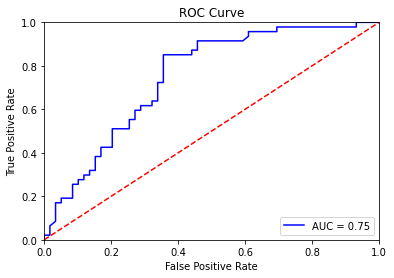

In [40]:
### Testing with the biger dataset
X_test, y_test=df40.loc[selector,:], ispoor[selector].to_numpy()
X_train, y_train=df40.loc[~selector,:], ispoor[~selector].to_numpy()

nbc2=NaiveBayesClassifier2(X_train,y_train)
y_pred2=nbc2.predict(X_test)

%time nbc3=NaiveBayesClassifierLaplace(X_train,y_train,alpha=.1)
%time y_pred3=nbc3.predict(X_test)
y_prob3=nbc3.predict_proba(X_test)[:,1]
print(sum(y_pred2))
print(sum(y_pred3))
ROC(y_test, y_prob3)

#### Calling sklearn.naive_bayes for Multinomial Naive Bayes

A good explanation from scikit-learn.org:  
https://scikit-learn.org/stable/modules/naive_bayes.html

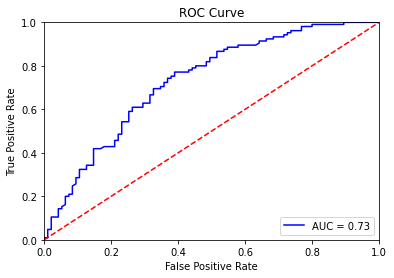

In [41]:
from sklearn.naive_bayes import MultinomialNB 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(df40, ispoor, test_size=0.2)

model = MultinomialNB(alpha=.0001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
ROC(y_test, y_prob)

### Methods available in sklearn.naive_bayes

<font style='font-size:18px; line-height:26px;'>
<br>
sklearn.naive_bayes includes
    
 - MultinomialNB (features are multinomially distributed)
 - ComplementNB (features are multinomially distributed but allow for imbalanced data sets)
 - BernoulliNB (each feature is assumed to be a binary-valued)
 - GaussianNB (features is assumed to be Gaussian)

</font>

Check: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

## Naive Bayes classification with non-structured data 
<br>
<font style='font-size:18px; line-height:26px;'>
We are now considering the spam email detection and we will use a dataset in SpamMsg.csv. This dataset is constructed with 5572 subject line from emails, each of them is labled with 'spam' or 'ham'. (Fake vs Genuine)
</font>

<font style='font-size:18px; line-height:26px;'>
This dataset is quite different from what we seen so far, all the information in one just one field $MSG$, this field has been cleaned, it is now all lower case, delimited by space. If we split each message by space and use each distinct word as a column and counting their occurence, we will have the follow table. This is traitionally all text are to be handled.
</font>

In [42]:
import pandas as pd
sms_spam = pd.read_csv('../data/SMSSpamCollection.txt', 
                       sep='\t', header=None, names=['Label', 'MSG'])
print(sms_spam.shape)
sms_spam.head()
sms_spam.iloc[6,:]

(5572, 2)


Label                                                  ham
MSG      Even my brother is not like to speak with me. ...
Name: 6, dtype: object

<font style='font-size:18px; line-height:26px;'>
    
It is acutally pretty easy to turn class NaiveBayesClassifierLaplas into a classifier that suitable for the classification of text. such as 

- 'WINNER!! This is the secret code to unlock the money: C3421.' ---> spam message
- "Sounds good, Tom, then see u there" ----> normal message

We are going to use NaiveBayesClassifierLaplace as a base because it has right structure for categorical-feature-only classification. All we need is to make changes on a few places:

1. There is just one input column: MSG, each MSG line is a short sentense, the number of word is not fixed, the word can be a English word od from other languages. Thus the statement key=F\[i\] need to be able to get multiple words from one space delimited sentense.

2. Since we are going to classify a sentense, we need to parse the sentense into multiple words, all of the words belong to field 'MSG'.

</font>

In [43]:
print(sms_spam.iloc[0,1])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


In [44]:
for i in range(5):
    print(sms_spam.iloc[i,1]) 

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [45]:
sms_spam['Label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

In [46]:
sms_spam['MSG']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: MSG, Length: 5572, dtype: object

In [47]:
sms_spam["MSG"]

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: MSG, Length: 5572, dtype: object

In [48]:
sms_spam.MSG


0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: MSG, Length: 5572, dtype: object

In [49]:
sms_spam.MSG.str.lower()

0       go until jurong point, crazy.. available only ...
1                           ok lar... joking wif u oni...
2       free entry in 2 a wkly comp to win fa cup fina...
3       u dun say so early hor... u c already then say...
4       nah i don't think he goes to usf, he lives aro...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                 will ü b going to esplanade fr home?
5569    pity, * was in mood for that. so...any other s...
5570    the guy did some bitching but i acted like i'd...
5571                           rofl. its true to its name
Name: MSG, Length: 5572, dtype: object

In [50]:
len(sms_spam.MSG.str.lower())

5572

In [51]:
sms_spam.head(5)

,Label,MSG
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [52]:
import re
## word case and punctuation
allsms = sms_spam.MSG.str.lower().replace('\W', ' ')  
allsms

0       go until jurong point, crazy.. available only ...
1                           ok lar... joking wif u oni...
2       free entry in 2 a wkly comp to win fa cup fina...
3       u dun say so early hor... u c already then say...
4       nah i don't think he goes to usf, he lives aro...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                 will ü b going to esplanade fr home?
5569    pity, * was in mood for that. so...any other s...
5570    the guy did some bitching but i acted like i'd...
5571                           rofl. its true to its name
Name: MSG, Length: 5572, dtype: object

In [53]:
a = '1$2af;a%'
a.replace('\W', ' ')

'1$2af;a%'

In [54]:
for i in range(5):
    print(allsms[i])
    type(allsms[i])

go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...
ok lar... joking wif u oni...
free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's
u dun say so early hor... u c already then say...
nah i don't think he goes to usf, he lives around here though


In [55]:
clean_sms=[]
vocabulary = set()
for msg in allsms:
    words = re.findall("[a-z0-9'$]+", msg)
    clean_sms.append(' '.join(words))
    for word in words:
        vocabulary.add(word)
len(vocabulary)

8926

In [56]:
print(words)
print(' '.join(words))
clean_sms

['rofl', 'its', 'true', 'to', 'its', 'name']
rofl its true to its name


['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 "free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry question std txt rate t c's apply 08452810075over18's",
 'u dun say so early hor u c already then say',
 "nah i don't think he goes to usf he lives around here though",
 "freemsg hey there darling it's been 3 week's now and no word back i'd like some fun you up for it still tb ok xxx std chgs to send 1 50 to rcv",
 'even my brother is not like to speak with me they treat me like aids patent',
 "as per your request 'melle melle oru minnaminunginte nurungu vettam ' has been set as your callertune for all callers press 9 to copy your friends callertune",
 'winner as a valued network customer you have been selected to receivea 900 prize reward to claim call 09061701461 claim code kl341 valid 12 hours only',
 'had your mobile 11 months or more u r entitled 

In [57]:
vocabulary

{'foregate',
 '150pm',
 'total',
 'eurodisinc',
 'daywith',
 'appy',
 'improve',
 '50',
 'walking',
 'cysts',
 'ave',
 '500',
 'membership',
 'between',
 'shirt',
 'monkeyaround',
 'hardly',
 "doesn't",
 'box245c2150pm',
 'hex',
 'haven',
 'selfish',
 'snake',
 'motor',
 'rinu',
 'sliding',
 'princes',
 'panic',
 '0quit',
 'fails',
 'm26',
 'm6',
 'soonlots',
 'waliking',
 'permanent',
 'goss',
 'internal',
 'tsunamis',
 '86888',
 "8'o",
 'jstfrnd',
 'helen',
 'stuffs',
 'london',
 'discreet',
 '2kbsubject',
 'whom',
 'flaky',
 'okay',
 'trusting',
 'pharmacy',
 'devils',
 'dirt',
 'hour',
 'lip',
 'potato',
 'bout',
 'dare',
 'screamed',
 'owo',
 'experiment',
 'tool',
 'sexiest',
 'wrking',
 'disconnect',
 'completed',
 'instantly',
 'stop2',
 'careers',
 'seventeen',
 'downloaded',
 '3days',
 'charles',
 'morn',
 'spile',
 'furniture',
 "er'ything",
 'wocay',
 '44',
 'shaved',
 'teaching',
 'dogwood',
 'inner',
 'speed',
 'steering',
 'female',
 'interviews',
 'bottle',
 '84122',
 '

In [58]:
print(allsms[2])
print(re.findall("[a-z0-9']+", allsms[2]))

free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's
['free', 'entry', 'in', '2', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', '21st', 'may', '2005', 'text', 'fa', 'to', '87121', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', "c's", 'apply', "08452810075over18's"]


In [59]:
a = ' XMU  xmu ! # % * 0 6   '
re.findall("[A-Za-z0-9'% ]+", a)

[' XMU  xmu ', ' ', ' % ', ' 0 6   ']

In [60]:
print(clean_sms)


['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat', 'ok lar joking wif u oni', "free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry question std txt rate t c's apply 08452810075over18's", 'u dun say so early hor u c already then say', "nah i don't think he goes to usf he lives around here though", "freemsg hey there darling it's been 3 week's now and no word back i'd like some fun you up for it still tb ok xxx std chgs to send 1 50 to rcv", 'even my brother is not like to speak with me they treat me like aids patent', "as per your request 'melle melle oru minnaminunginte nurungu vettam ' has been set as your callertune for all callers press 9 to copy your friends callertune", 'winner as a valued network customer you have been selected to receivea 900 prize reward to claim call 09061701461 claim code kl341 valid 12 hours only', 'had your mobile 11 months or more u r entitled to update

In [61]:
print(len(clean_sms))

5572


In [62]:
sms = clean_sms[0]
print(sms)
sms.split(' ')

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat


['go',
 'until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'there',
 'got',
 'amore',
 'wat']

In [63]:
a = "xmu class econ 9 10 20"
a.split(' ')

['xmu', 'class', 'econ', '9', '10', '20']

In [2]:
[0]*3
len([[],[]])

2

In [65]:
word_counts_per_sms = {unique_word: [0] * len(clean_sms) for unique_word in vocabulary}
#每个word对应一个[0,0,...,0]，维度为x的数量
for i, sms in enumerate(clean_sms): #对每一句话
    for word in sms.split(' '): #对每句话的每一个word
        if word!='':
            word_counts_per_sms[word][i] += 1 #算每个word来自每个句子，分别来自了多少次

In [66]:
word_counts_per_sms.keys()

dict_keys(['foregate', '150pm', 'total', 'eurodisinc', 'daywith', 'appy', 'improve', '50', 'walking', 'cysts', 'ave', '500', 'membership', 'between', 'shirt', 'monkeyaround', 'hardly', "doesn't", 'box245c2150pm', 'hex', 'haven', 'selfish', 'snake', 'motor', 'rinu', 'sliding', 'princes', 'panic', '0quit', 'fails', 'm26', 'm6', 'soonlots', 'waliking', 'permanent', 'goss', 'internal', 'tsunamis', '86888', "8'o", 'jstfrnd', 'helen', 'stuffs', 'london', 'discreet', '2kbsubject', 'whom', 'flaky', 'okay', 'trusting', 'pharmacy', 'devils', 'dirt', 'hour', 'lip', 'potato', 'bout', 'dare', 'screamed', 'owo', 'experiment', 'tool', 'sexiest', 'wrking', 'disconnect', 'completed', 'instantly', 'stop2', 'careers', 'seventeen', 'downloaded', '3days', 'charles', 'morn', 'spile', 'furniture', "er'ything", 'wocay', '44', 'shaved', 'teaching', 'dogwood', 'inner', 'speed', 'steering', 'female', 'interviews', 'bottle', '84122', 'behalf', '09066364589', '15', 'kanagu', 'buzz', 'vid', '730', 'ethnicity', 'gas

In [67]:
word_counts = pd.DataFrame(word_counts_per_sms, dtype=np.int16)
word_counts.head()

,foregate,150pm,total,eurodisinc,daywith,appy,improve,50,walking,cysts,...,notixiquating,f,mei,07,lifting,gift,ignoring,openings,dvg,tihs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
(np.array(word_counts)>1).sum()

6066

In [69]:
word_counts['go']

0       1
1       0
2       0
3       0
4       0
       ..
5567    0
5568    0
5569    0
5570    0
5571    0
Name: go, Length: 5572, dtype: int16

In [70]:
clean_set= pd.concat([sms_spam, word_counts], axis=1) #链接原始句子和word的计数
clean_set.head()

,Label,MSG,foregate,150pm,total,eurodisinc,daywith,appy,improve,50,...,notixiquating,f,mei,07,lifting,gift,ignoring,openings,dvg,tihs
0,ham,"Go until jurong point, crazy.. Available only ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,Ok lar... Joking wif u oni...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,U dun say so early hor... U c already then say...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# Randomize the dataset
data_randomized = sms_spam.sample(frac=1, random_state=1)

# Calculate index for split
training_test_index = round(len(data_randomized) * 0.8)

# Split into training and test sets
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True) #重置索引，并丢弃旧索引列。

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [72]:
X_train = clean_set
# Isolating spam and ham messages first
spam_messages = X_train[X_train.Label == 'spam']
ham_messages = X_train[X_train.Label == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(X_train)
p_ham = len(ham_messages) / len(X_train) #prior

# N_Spam
n_words_per_spam_message = spam_messages['MSG'].apply(len) #每个spam句子的长度
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['MSG'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

In [73]:
print(n_spam,n_ham,n_vocabulary)

103587 344903 8926


In [74]:
vocabulary

{'foregate',
 '150pm',
 'total',
 'eurodisinc',
 'daywith',
 'appy',
 'improve',
 '50',
 'walking',
 'cysts',
 'ave',
 '500',
 'membership',
 'between',
 'shirt',
 'monkeyaround',
 'hardly',
 "doesn't",
 'box245c2150pm',
 'hex',
 'haven',
 'selfish',
 'snake',
 'motor',
 'rinu',
 'sliding',
 'princes',
 'panic',
 '0quit',
 'fails',
 'm26',
 'm6',
 'soonlots',
 'waliking',
 'permanent',
 'goss',
 'internal',
 'tsunamis',
 '86888',
 "8'o",
 'jstfrnd',
 'helen',
 'stuffs',
 'london',
 'discreet',
 '2kbsubject',
 'whom',
 'flaky',
 'okay',
 'trusting',
 'pharmacy',
 'devils',
 'dirt',
 'hour',
 'lip',
 'potato',
 'bout',
 'dare',
 'screamed',
 'owo',
 'experiment',
 'tool',
 'sexiest',
 'wrking',
 'disconnect',
 'completed',
 'instantly',
 'stop2',
 'careers',
 'seventeen',
 'downloaded',
 '3days',
 'charles',
 'morn',
 'spile',
 'furniture',
 "er'ything",
 'wocay',
 '44',
 'shaved',
 'teaching',
 'dogwood',
 'inner',
 'speed',
 'steering',
 'female',
 'interviews',
 'bottle',
 '84122',
 '

In [75]:
spam_messages['i'].sum()
ham_messages['you'].sum()

1866

In [76]:
# Initiate dictionary
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum() # 统计单词 word 在所有垃圾邮件（Spam）中的总出现次数。
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam #likelihood

    n_word_given_ham = ham_messages[word].sum() # ham_messages already defined
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

In [77]:
import re

def classify(message):
    message = re.sub('\W', ' ', message)
    message = message.lower().split()

    p_spam_given_message = p_spam #prior
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word] #calc posteriori

        if word in parameters_ham: 
            p_ham_given_message *= parameters_ham[word]

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [78]:
classify('WINNER!! This is the secret code to unlock the money: C3421')

P(Spam|message): 5.70617222779413e-31
P(Ham|message): 2.580900087836799e-33
Label: Spam


In [79]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 1.4849398404655836e-29
P(Ham|message): 9.580580976071317e-26
Label: Ham


In [80]:
classify("You have been compensated by united nation with the sum of 3.5 million Euros,")

P(Spam|message): 6.163229378772029e-45
P(Ham|message): 7.074647891619426e-45
Label: Ham


In [81]:
classify("Thank you")

P(Spam|message): 6.163495302732219e-09
P(Ham|message): 3.7449125075873505e-07
Label: Ham


### Do we need so many columns ?

In [82]:
from sklearn.model_selection import train_test_split
sms = pd.read_csv('../data/SMSSpamCollection.txt', sep='\t', header=None, names=['Label', 'MSG'])

X_train, X_test, y_train, y_test= train_test_split(sms.MSG.to_numpy(), sms.Label.to_numpy(),
                                                   test_size=0.2,random_state=100)
training_set=X_train

spam_messages=X_train[y_train=='spam']
ham_messages=X_train[y_train=='ham']

# P(Spam) and P(Ham)
allcount=len(spam_messages)+len(ham_messages)
p_spam = len(spam_messages)/allcount
p_ham = len(ham_messages)/allcount

vocabulary = set()
spam_wordcount={}
ham_wordcount={}

for sms in spam_messages: #针对每个垃圾句子统计每个unique的单词的词频
     for word in str(sms).split(' '):
        vocabulary.add(word)
        if word in spam_wordcount:
            spam_wordcount[word]+=1
        else:
            spam_wordcount[word]=1
for sms in ham_messages:
     for word in str(sms).split(' '):
        vocabulary.add(word)
        if word in ham_wordcount:
            ham_wordcount[word]+=1
        else:
            ham_wordcount[word]=1
# N_Spam
n_spam = sum(spam_wordcount.values()) #总次数
# N_Ham
n_ham = sum(ham_wordcount.values())

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

# Initiate parameters
parameters_spam = {}
parameters_ham={}
for word in spam_wordcount:
    parameters_spam[word]=(spam_wordcount[word]+ alpha)/(n_spam + alpha*n_vocabulary)
for word in ham_wordcount:
    parameters_ham[word]=(ham_wordcount[word]+ alpha)/(n_ham + alpha*n_vocabulary)

def classify(message):
    message = re.sub('\W', ' ', message)
    message = message.lower().split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        else:
            p_spam_given_message *= alpha / (n_spam + alpha*n_vocabulary) 
            
        if word in parameters_ham: 
            p_ham_given_message *= parameters_ham[word]
        else:
            p_ham_given_message *= alpha/(n_ham + alpha*n_vocabulary)

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')
        
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.8250879721481917e-36
P(Ham|message): 4.0702952330812645e-38
Label: Spam


In [83]:
class SpamFilter:
    def __init__(self, x_train, y_train, alpha=1):
        
        spam_messages=X_train[y_train=='spam']
        ham_messages=X_train[y_train=='ham']

        # P(Spam) and P(Ham)
        allcount=len(spam_messages)+len(ham_messages)
        self.p_spam = len(spam_messages)/allcount
        self.p_ham = len(ham_messages)/allcount
        
        self.vocabulary = set()
        spam_wordcount={}
        ham_wordcount={}

        for sms in spam_messages:
             for word in str(sms).split(' '):
                self.vocabulary.add(word)
                if word in spam_wordcount:
                    spam_wordcount[word]+=1
                else:
                    spam_wordcount[word]=1
        for sms in ham_messages:
             for word in str(sms).split(' '):
                self.vocabulary.add(word)
                if word in ham_wordcount:
                    ham_wordcount[word]+=1
                else:
                    ham_wordcount[word]=1
        
        # N_Spam
        n_spam = sum(spam_wordcount.values())
        # N_Ham
        n_ham = sum(ham_wordcount.values())

        # N_Vocabulary
        self.n_vocabulary = len(vocabulary)
        self.laplace_spam=alpha / (n_spam + alpha*n_vocabulary)
        self.laplace_ham=alpha / (n_ham + alpha*n_vocabulary)
        
        # Initiate parameters
        self.parameters_spam = {}
        self.parameters_ham={}
        for word in spam_wordcount:
            self.parameters_spam[word]=(spam_wordcount[word]+ alpha) / (n_spam + alpha*n_vocabulary)
        for word in ham_wordcount:
            self.parameters_ham[word]=(ham_wordcount[word]+ alpha) / (n_ham + alpha*n_vocabulary)

    def classify(self, message):
        message=str(message)
        message = re.sub('\W', ' ', message)
        message = message.lower().split()

        p_spam_given_message = self.p_spam
        p_ham_given_message = self.p_ham

        for word in message:
            if word in self.parameters_spam:
                p_spam_given_message *= self.parameters_spam[word]
            else:
                p_spam_given_message *= self.laplace_spam

            if word in self.parameters_ham: 
                p_ham_given_message *= self.parameters_ham[word]
            else:
                p_ham_given_message *= self.laplace_ham

        if p_ham_given_message > p_spam_given_message:
            return 'Ham'
        elif p_ham_given_message <= p_spam_given_message:
            return 'Spam'

from sklearn.model_selection import train_test_split
sms = pd.read_csv('../data/SMSSpamCollection.txt', sep='\t', header=None, names=['Label', 'MSG'])
X_train, X_test, y_train, y_test= train_test_split(sms.MSG.to_numpy(), sms.Label.to_numpy(),
                                                   test_size=0.2,random_state=100)

sf=SpamFilter(X_train, y_train)
sf.classify('WINNER!! This is the secret code to unlock the money: C3421.')

'Spam'

In [84]:
print(sf.classify('WINNER!! This is the secret code to unlock the money: C3421.'))
print(sf.classify("Sounds good, Tom, then see u there"))
print(sf.classify("this is a dog"))
print(sf.classify("You have been compensated by united nation with the sum of 3.5 million Euros, We have instructed the Santander bank to credit the fund into ATM card and send to you in your country All you have to do right now is to provide your home address a copy of your identity card and your WhatsApp number for easy communication,"))

Spam
Ham
Ham
Ham


#### Magic is behind the difference probabilities

In [85]:
word_probs=[]
for word in sf.vocabulary:
    if word in sf.parameters_spam and word in sf.parameters_ham:
        p_spam_given_message = sf.parameters_spam[word]
        p_ham_given_message = sf.parameters_ham[word]
        word_probs.append([word, p_spam_given_message, p_ham_given_message, p_spam_given_message-p_ham_given_message])
word_probs_df=pd.DataFrame(word_probs, columns=['word', 'prob_spam', 'prob_ham', 'prob_diff'])     
word_probs_df=word_probs_df.sort_values('prob_diff',ascending=False)
word_probs_df.head(50)

,word,prob_spam,prob_ham,prob_diff
827,Call,0.004171,0.000274,0.003897
127,or,0.005419,0.002074,0.003344
969,call,0.005561,0.002334,0.003227
402,&,0.002816,0.000173,0.002643
829,FREE,0.002602,0.000029,0.002573
918,mobile,0.002424,0.000158,0.002266
236,To,0.002175,0.000072,0.002103
648,from,0.003529,0.001527,0.002002
329,Your,0.002353,0.000360,0.001993
931,txt,0.001961,0.000101,0.001860
